In [1]:
import sys
from pathlib import Path
project_root = Path('./').resolve().parent
sys.path.append(str(project_root))

In [2]:
from utils.utils import load_yaml_config, concordance_index
from models.ensembles import Ensembles
import numpy as np
from matminer.featurizers.composition import ElementProperty
import pandas as pd

In [3]:
path_config = Path('./').resolve().parent / 'configs' / 'ensembles.yaml'
config = load_yaml_config(path_config)

In [4]:
config['data']['root_dir']=Path('./').resolve().parent / config['data']['root_dir']

In [5]:
config['features']['checkpoint_path']=Path('./').resolve().parent / config['features']['checkpoint_path']

In [6]:
model = Ensembles(**config)
model.prep_data()

RandomForestRegressor(random_state=11)


/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/io/cif.py:1324: UserWarning: Issues encountered while parsing CIF: 16 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/io/cif.py:1324: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/io/cif.py:1324: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/io/cif.py:1

** Features are being calculated **


/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/libpyg.so, 0x0006): Library not loaded: /Library/Frameworks/Python.framework/Versions/3.11/Python
  Referenced from: <CA14ED34-FA3D-31FE-B4AD-2B2A8446B324> /opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/libpyg.so
  Reason: tried: '/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file), '/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file)
  import torch_geometric.typing
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/opt/miniconda3/envs/kpoint

test_ratio 1.0, train_ratio 0.0
calibration False, cal_ratio 0.0


In [14]:
from sklearn.model_selection import train_test_split

In [8]:
model.random_seed=11111

In [9]:
train_ind, test_ind = train_test_split(model.data.index.values, 
                                               test_size=model.test_ratio, 
                                               random_state=model.random_seed)
train_ind, cal_ind = train_test_split(train_ind, 
                                               test_size=model.test_ratio, 
                                               random_state=model.random_seed)
ytrain = np.array(model.data.iloc[train_ind][1].values,dtype='float')
ytest = np.array(model.data.iloc[test_ind][1].values,dtype='float')
ycal = np.array(model.data.iloc[cal_ind][1].values,dtype='float')
Xtrain = model.features[train_ind,:]
Xtest = model.features[test_ind,:]
Xcal = model.features[cal_ind,:]

In [10]:
from sklearn.ensemble import RandomForestRegressor

In [11]:
model1=RandomForestRegressor()
model1.fit(Xtrain,ytrain)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
ypred = model1.predict(Xtest)

In [15]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import spearmanr, kendalltau

mse = mean_squared_error(ytest, ypred)
mae = mean_absolute_error(ytest, ypred)
mape = mean_absolute_percentage_error(ytest, ypred)
r2 = r2_score(ytest, ypred)
spearman_corr, _ = spearmanr(ytest, ypred)
kendall_corr, _ = kendalltau(ytest, ypred)
    # c_index = concordance_index(y_test, y_pred[strategy])

print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')
print(f'Test set spearman_corr: {spearman_corr}')
print(f'Test set kendall_corr: {kendall_corr}')

Test set MAE: 0.06829595430165775
Test set MAPE: 0.21430445537219778
Test set MSE: 0.009032652980053476
Test set R2 score: 0.6910229954607142
Test set spearman_corr: 0.8477685241723294
Test set kendall_corr: 0.6595577826335415


## Feature sizes

In [18]:
from utils.compound_features_utils import matminer_composition_features, matminer_structure_features
from utils.compound_features_utils import soap_features, jarvis_features, lattice_features, cgcnn_features 

In [19]:
list_of_feat = [k for k, v in model.composition_features.items() if v]
composition_features = matminer_composition_features(model.data[:10], list_of_feat)
composition_features.shape

/Users/elena.patyukova/Documents/github/clean-kpoints/goldilocks_kpoints/utils/utils.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[formula_column]=formula
/Users/elena.patyukova/Documents/github/clean-kpoints/goldilocks_kpoints/utils/compound_features_utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['composition'] = [Composition(form) for form in df[formula_column]]


(10, 146)

In [20]:
list_of_feat = [k for k, v in model.structure_features.items() if v]
structure_features = matminer_structure_features(model.data[:10], list_of_feat)
structure_features.shape

(10, 6)

In [21]:
soap_f = soap_features(model.data[:10],model.soap_params)
soap_f.shape

(10, 252)

In [22]:
lattice_f = lattice_features(model.data[:10])
lattice_f.shape

(10, 15)

In [23]:
cgcnn_f = cgcnn_features(model.checkpoint_path, model.path, model.lmdb_exist)
cgcnn_f.shape

/Users/elena.patyukova/Documents/github/clean-kpoints/goldilocks_kpoints/utils/compound_features_utils.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = tor

test_ratio 1.0, train_ratio 0.0
calibration False, cal_ratio 0.0


(20178, 64)

## First iteration surrogate model

In [25]:
from sklearn.tree import DecisionTreeRegressor

surrogate = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=40,  # for stability
)

In [24]:
y_pred=model1.predict(Xtrain)

In [26]:
surrogate.fit(Xtrain, y_pred)

,criterion,'squared_error'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,40
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [28]:
from sklearn.metrics import r2_score

fidelity = r2_score(y_pred, surrogate.predict(Xtrain))
print("Fidelity to RF:", fidelity)

Fidelity to RF: 0.7089827747258965


/var/folders/v7/cqz0y8fn2sjc927rqlt460_m0000gp/T/ipykernel_28660/4044995433.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14,frameon=False)


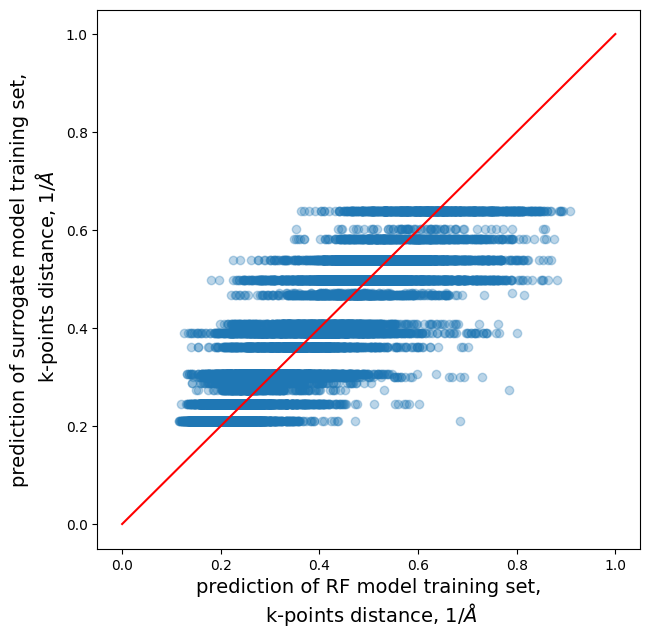

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_pred,surrogate.predict(Xtrain), alpha=0.3)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('prediction of RF model training set,\n k-points distance, $1/\AA$',fontsize=14)
plt.ylabel('prediction of surrogate model training set,\n k-points distance, $1/\AA$',fontsize=14)
plt.legend(fontsize=14,frameon=False)
plt.savefig("../figures/RF_best.png", dpi=300)
plt.show()

/var/folders/v7/cqz0y8fn2sjc927rqlt460_m0000gp/T/ipykernel_28660/1887447807.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14,frameon=False)


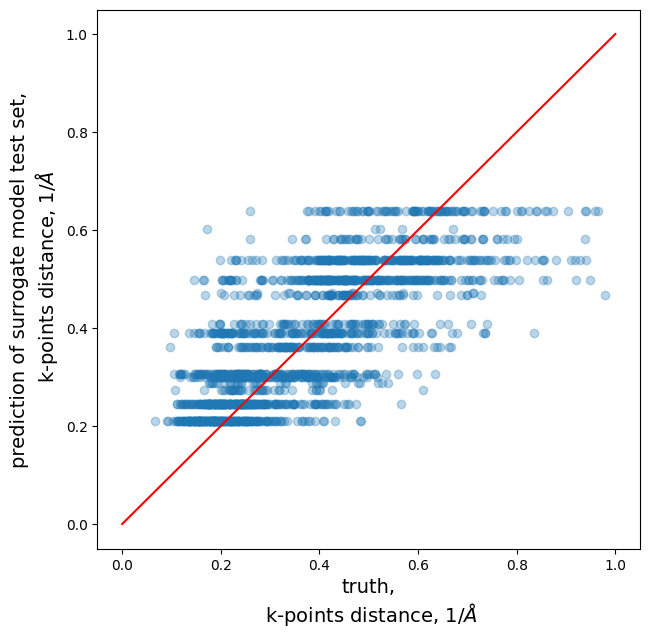

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(ytest,surrogate.predict(Xtest), alpha=0.3)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('truth,\n k-points distance, $1/\AA$',fontsize=14)
plt.ylabel('prediction of surrogate model test set,\n k-points distance, $1/\AA$',fontsize=14)
plt.legend(fontsize=14,frameon=False)
plt.savefig("../figures/RF_best.png", dpi=300)
plt.show()

In [62]:
from sklearn.tree import export_text

rules = export_text(surrogate, feature_names=np.linspace(0, Xtrain.shape[1]-1,Xtrain.shape[1]))
print(rules)

|--- 23.0 <= 202.96
|   |--- 418.0 <= 37.50
|   |   |--- 33.0 <= 2.47
|   |   |   |--- 149.0 <= 2.70
|   |   |   |   |--- value: [0.64]
|   |   |   |--- 149.0 >  2.70
|   |   |   |   |--- value: [0.58]
|   |   |--- 33.0 >  2.47
|   |   |   |--- 33.0 <= 3.18
|   |   |   |   |--- value: [0.54]
|   |   |   |--- 33.0 >  3.18
|   |   |   |   |--- value: [0.47]
|   |--- 418.0 >  37.50
|   |   |--- 468.0 <= -0.00
|   |   |   |--- 432.0 <= -0.24
|   |   |   |   |--- value: [0.39]
|   |   |   |--- 432.0 >  -0.24
|   |   |   |   |--- value: [0.29]
|   |   |--- 468.0 >  -0.00
|   |   |   |--- 33.0 <= 3.18
|   |   |   |   |--- value: [0.50]
|   |   |   |--- 33.0 >  3.18
|   |   |   |   |--- value: [0.41]
|--- 23.0 >  202.96
|   |--- 442.0 <= -0.32
|   |   |--- 162.0 <= 11.26
|   |   |   |--- 440.0 <= 0.52
|   |   |   |   |--- value: [0.31]
|   |   |   |--- 440.0 >  0.52
|   |   |   |   |--- value: [0.36]
|   |   |--- 162.0 >  11.26
|   |   |   |--- 33.0 <= 2.47
|   |   |   |   |--- value: [0.60]
|

In [40]:
comp_cols=np.linspace(0,composition_features.shape[1]-1,composition_features.shape[1],dtype=int)
structure_cols=np.linspace(composition_features.shape[1],composition_features.shape[1]+structure_features.shape[1]-1,structure_features.shape[1],dtype=int)
soap_cols=np.linspace(composition_features.shape[1]+structure_features.shape[1],composition_features.shape[1]+structure_features.shape[1]+soap_f.shape[1]-1,soap_f.shape[1],dtype=int)
lattice_cols=np.linspace(composition_features.shape[1]+structure_features.shape[1]+soap_f.shape[1],composition_features.shape[1]+structure_features.shape[1]+soap_f.shape[1]+lattice_f.shape[1]-1,lattice_f.shape[1],dtype=int)
cgcnn_cols=np.linspace(composition_features.shape[1]+structure_features.shape[1]+soap_f.shape[1]+lattice_f.shape[1],composition_features.shape[1]+structure_features.shape[1]+soap_f.shape[1]+lattice_f.shape[1]+cgcnn_f.shape[1]-1,cgcnn_f.shape[1],dtype=int)

In [70]:
len(structure_cols)-len(Density_labels)-len(GS_labels)

-2

In [71]:
GlobalSymmetryFeatures().feature_labels()

['spacegroup_num',
 'crystal_system',
 'crystal_system_int',
 'is_centrosymmetric',
 'n_symmetry_ops']

In [78]:
from matminer.featurizers.composition import *
from matminer.featurizers.structure import *

El_Prop_feat_labels = ElementProperty.from_preset("magpie").feature_labels()
El_Prop_cols=np.linspace(0,len(El_Prop_feat_labels)-1,len(El_Prop_feat_labels),dtype=int)
Stoichiometry_labels = Stoichiometry().feature_labels()
Stoichiometry_cols=np.linspace(len(El_Prop_feat_labels),len(El_Prop_feat_labels)+len(Stoichiometry_labels),len(Stoichiometry_labels),dtype=int)
ValenceOrbital_labels = ValenceOrbital().feature_labels()
ValenceOrbital_cols = np.linspace(len(El_Prop_feat_labels)+len(Stoichiometry_labels),len(El_Prop_feat_labels)+len(Stoichiometry_labels)+len(ValenceOrbital_labels),len(ValenceOrbital_labels),dtype=int)
GS_labels=["spacegroup_num", "crystal_system_int", "is_centrosymmetric"]
GS_cols=np.linspace(composition_features.shape[1],composition_features.shape[1]+len(GS_labels),len(GS_labels),dtype=int)
Density_labels= ["density", "vpa", "packing fraction"]
Density_cols=np.linspace(composition_features.shape[1]+len(GS_labels),composition_features.shape[1]+len(GS_labels)+len(Density_labels),len(Density_labels),dtype=int)
Lattice_labels=['a','b','c','alpha','beta','gamma','inverse_a','iverse_b','inverse_c','inverse_alpha','inverse_beta','inverse_gamma','crystal_system_id','bravais_id',"spacegroup_num"]

In [82]:
Soap_labels=[]
for i in range(soap_f.shape[1]):
    Soap_labels.append('soap'+str(i))
metal_labels=[]
for i in range(cgcnn_f.shape[1]):
    metal_labels.append('metal'+str(i))

In [73]:
feature_names=np.linspace(1, Xtrain.shape[1],Xtrain.shape[1],dtype=int)
features_used_named = {
    i: feature_names[tree.feature[i]]
    for i in range(tree.node_count)
    if tree.feature[i] != _tree.TREE_UNDEFINED
}

print(features_used_named)

{0: np.int64(24), 1: np.int64(419), 2: np.int64(34), 3: np.int64(150), 6: np.int64(34), 9: np.int64(469), 10: np.int64(433), 13: np.int64(34), 16: np.int64(443), 17: np.int64(163), 18: np.int64(441), 21: np.int64(34), 24: np.int64(37), 25: np.int64(147), 28: np.int64(100)}


In [81]:
for node_count, name in features_used_named.items():
    if name in comp_cols:
        if name in El_Prop_cols:
            print(f'node{node_count}: {name}, {El_Prop_feat_labels[name]}')
        elif name in Stoichiometry_cols:
            print(f'node{node_count}: {name}, {Stoichiometry_labels[name-len(El_Prop_feat_labels)]}')
        elif name in ValenceOrbital_cols:
            print(f'node{node_count}: {name}, {ValenceOrbital_labels[name-len(El_Prop_feat_labels)-len(Stoichiometry_labels)]}')
    elif name in structure_cols:
        if name in GS_cols:
            print(f'node{node_count}: {name}, {GS_labels[name-composition_features.shape[1]]}')
        if name in Density_cols:
            print(f'node{node_count}: {name}, {Density_labels[name-len(GS_labels)-composition_features.shape[1]]}')
    elif name in soap_cols:
        print(f'node{node_count}: {name}, soap {name-composition_features.shape[1]-structure_features.shape[1]}')
    elif name in lattice_cols:
        print(f'node{node_count}: {name}, lattice, {Lattice_labels[name-composition_features.shape[1]-structure_features.shape[1]-soap_f.shape[1]]}')
    elif name in cgcnn_cols:
        print(f'node{node_count}: {name}, metal {name-composition_features.shape[1]-structure_features.shape[1]-lattice_f.shape[1]-soap_f.shape[1]}')

node0: 24, MagpieData minimum Column
node1: 419, metal 0
node2: 34, MagpieData avg_dev Row
node3: 150, vpa
node6: 34, MagpieData avg_dev Row
node9: 469, metal 50
node10: 433, metal 14
node13: 34, MagpieData avg_dev Row
node16: 443, metal 24
node17: 163, soap 11
node18: 441, metal 22
node21: 34, MagpieData avg_dev Row
node24: 37, MagpieData maximum CovalentRadius
node25: 147, crystal_system_int
node28: 100, MagpieData avg_dev NfUnfilled


In [83]:
feature_names=np.concatenate([El_Prop_feat_labels,Stoichiometry_labels, ValenceOrbital_labels, GS_labels, Density_labels, Soap_labels, Lattice_labels, metal_labels])

In [85]:
from sklearn.tree import export_text

rules = export_text(surrogate, feature_names=feature_names)
print(rules)

|--- MagpieData mode MeltingT <= 202.96
|   |--- spacegroup_num <= 37.50
|   |   |--- MagpieData mean Row <= 2.47
|   |   |   |--- density <= 2.70
|   |   |   |   |--- value: [0.64]
|   |   |   |--- density >  2.70
|   |   |   |   |--- value: [0.58]
|   |   |--- MagpieData mean Row >  2.47
|   |   |   |--- MagpieData mean Row <= 3.18
|   |   |   |   |--- value: [0.54]
|   |   |   |--- MagpieData mean Row >  3.18
|   |   |   |   |--- value: [0.47]
|   |--- spacegroup_num >  37.50
|   |   |--- metal49 <= -0.00
|   |   |   |--- metal13 <= -0.24
|   |   |   |   |--- value: [0.39]
|   |   |   |--- metal13 >  -0.24
|   |   |   |   |--- value: [0.29]
|   |   |--- metal49 >  -0.00
|   |   |   |--- MagpieData mean Row <= 3.18
|   |   |   |   |--- value: [0.50]
|   |   |   |--- MagpieData mean Row >  3.18
|   |   |   |   |--- value: [0.41]
|--- MagpieData mode MeltingT >  202.96
|   |--- metal23 <= -0.32
|   |   |--- soap10 <= 11.26
|   |   |   |--- metal21 <= 0.52
|   |   |   |   |--- value: [0

## Reducing dimensionality of features

In [94]:
Xtrain_soap=Xtrain.copy()
Xtrain_soap=Xtrain_soap[:,soap_cols]

In [95]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(Xtrain_soap)

,n_components,5
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [96]:
Xtrain_soap=pca.transform(Xtrain_soap)
Xtest_soap=Xtest.copy()
Xtest_soap=Xtest_soap[:,soap_cols]
Xtest_soap=pca.transform(Xtest_soap)

In [97]:
Xtrain_cgcnn=Xtrain.copy()
Xtrain_cgcnn=Xtrain_cgcnn[:,cgcnn_cols]
pca = PCA(n_components=5)
pca.fit(Xtrain_cgcnn)
Xtrain_cgcnn=pca.transform(Xtrain_cgcnn)

In [98]:
Xtest_cgcnn=Xtest.copy()
Xtest_cgcnn=Xtest_cgcnn[:,cgcnn_cols]
Xtest_cgcnn=pca.transform(Xtest_cgcnn)

In [99]:
Xtrain_comp=Xtrain.copy()
comp_selection=[3,23,33,36,39,44,97,99,143]
Xtrain_comp=Xtrain_comp[:,comp_selection]
Xtest_comp=Xtest[:,comp_selection]

In [ ]:
comp_labels_int=[]
for name in [3,23,33,36,39,44,97,99,143]:
    if name in comp_cols:
        if name in El_Prop_cols:
           comp_labels_int.append(El_Prop_feat_labels[name])
        elif name in Stoichiometry_cols:
           comp_labels_int.append(Stoichiometry_labels[name-len(El_Prop_feat_labels)])
        elif name in ValenceOrbital_cols:
           comp_labels_int.append(ValenceOrbital_labels[name-len(El_Prop_feat_labels)-len(Stoichiometry_labels)])
    elif name in structure_cols:
        if name in GS_cols:
            comp_labels_int.append(GS_labels[name-composition_features.shape[1]])
        if name in Density_cols:
            comp_labels_int.append(Density_labels[name-len(GS_labels)-composition_features.shape[1]])

In [100]:
Xtest_lattice=Xtest[:,[418]]
Xtrain_lattice=Xtrain[:,[418]]

In [101]:
Xtrain_int=np.concat([Xtrain_comp,Xtrain_soap,Xtrain_lattice,Xtrain_cgcnn], axis=1)
Xtest_int=np.concat([Xtest_comp,Xtest_soap,Xtest_lattice,Xtest_cgcnn], axis=1)

In [111]:
feature_names_int=np.concat([comp_labels_int,['soap0','soap1','soap2','soap3','soap4'],['space_group_num'],['metal0','metal1','metal2','metal3','metal4']])

## Surrogate model

In [103]:
model2=RandomForestRegressor()
model2.fit(Xtrain_int, ytrain)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [104]:
ypred2=model2.predict(Xtest_int)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import spearmanr, kendalltau

mse = mean_squared_error(ytest, ypred2)
mae = mean_absolute_error(ytest, ypred2)
mape = mean_absolute_percentage_error(ytest, ypred2)
r2 = r2_score(ytest, ypred2)
spearman_corr, _ = spearmanr(ytest, ypred2)
kendall_corr, _ = kendalltau(ytest, ypred2)
    # c_index = concordance_index(y_test, y_pred[strategy])

print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')
print(f'Test set spearman_corr: {spearman_corr}')
print(f'Test set kendall_corr: {kendall_corr}')

Test set MAE: 0.072132476198646
Test set MAPE: 0.22595081785209628
Test set MSE: 0.009863667197446729
Test set R2 score: 0.6625967640770077
Test set spearman_corr: 0.8332202190837615
Test set kendall_corr: 0.6419325721456813


In [102]:
from sklearn.tree import DecisionTreeRegressor

surrogate = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=40, 
)

In [105]:
y_pred_train=model2.predict(Xtrain_int)

In [106]:
surrogate.fit(Xtrain_int, y_pred_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,40
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [107]:
from sklearn.metrics import r2_score

fidelity = r2_score(y_pred_train, surrogate.predict(Xtrain_int))
print("Fidelity to RF:", fidelity)

Fidelity to RF: 0.7152576466969104


In [112]:
from sklearn.tree import export_text

rules = export_text(surrogate, feature_names=feature_names_int)
print(rules)

|--- MagpieData mode MeltingT <= 202.96
|   |--- space_group_num <= 37.50
|   |   |--- MagpieData mean Row <= 2.52
|   |   |   |--- MagpieData mean Number <= 9.22
|   |   |   |   |--- value: [0.65]
|   |   |   |--- MagpieData mean Number >  9.22
|   |   |   |   |--- value: [0.59]
|   |   |--- MagpieData mean Row >  2.52
|   |   |   |--- MagpieData mean Row <= 3.18
|   |   |   |   |--- value: [0.54]
|   |   |   |--- MagpieData mean Row >  3.18
|   |   |   |   |--- value: [0.47]
|   |--- space_group_num >  37.50
|   |   |--- metal0 <= -2.88
|   |   |   |--- MagpieData mean Row <= 3.17
|   |   |   |   |--- value: [0.50]
|   |   |   |--- MagpieData mean Row >  3.17
|   |   |   |   |--- value: [0.41]
|   |   |--- metal0 >  -2.88
|   |   |   |--- metal0 <= 0.92
|   |   |   |   |--- value: [0.39]
|   |   |   |--- metal0 >  0.92
|   |   |   |   |--- value: [0.30]
|--- MagpieData mode MeltingT >  202.96
|   |--- frac p valence electrons <= 0.19
|   |   |--- MagpieData minimum CovalentRadius <= 